In [1]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

Cloning into 'german-traffic-signs'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (6/6), 117.80 MiB | 10.00 MiB/s, done.
Updating files: 100% (4/4), done.


In [2]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import pickle
import pandas as pd
import random

In [4]:
with open('german-traffic-signs/train.p', 'rb') as f:
  train_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
  val_data = pickle.load(f)
with open('german-traffic-signs/test.p', 'rb') as f:
  test_data = pickle.load(f)

print(type(train_data))

X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

<class 'dict'>


In [5]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_val.shape[0])

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)
4410


In [6]:
assert(X_train.shape[0] == y_train.shape[0]), "Num of images ain't equal to num of labels"
assert(X_val.shape[0] == y_val.shape[0]), "Num of images ain't equal to num of labels"
assert(X_test.shape[0] == y_test.shape[0]), "Num of images ain't equal to num of labels"
assert(X_train.shape[1:] == (32,32,3)), "Images are not 32x32x3"
assert(X_val.shape[1:] == (32,32,3)), "Images are not 32x32x3"
assert(X_test.shape[1:] == (32,32,3)), "Images are not 32x32x3"

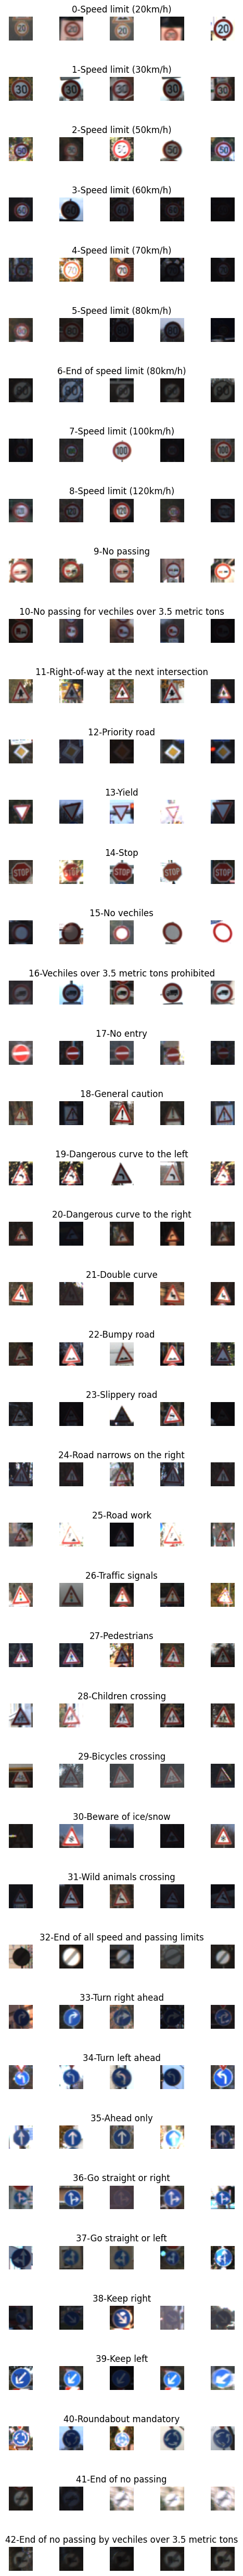

In [7]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
num_of_samples = []

cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows = num_classes, ncols = cols, figsize=(5, 50))
fig.tight_layout()

for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, (len(x_selected) - 1)), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + "-" + row['SignName'])
            num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


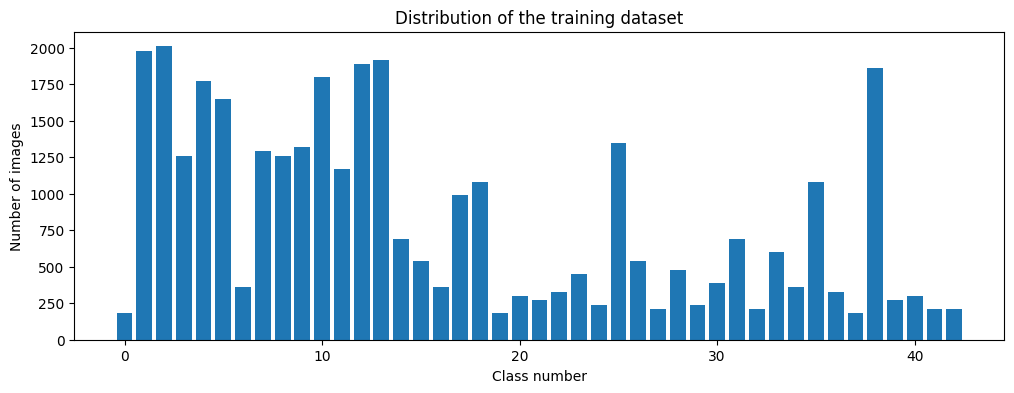

In [8]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

(32, 32, 3)
36


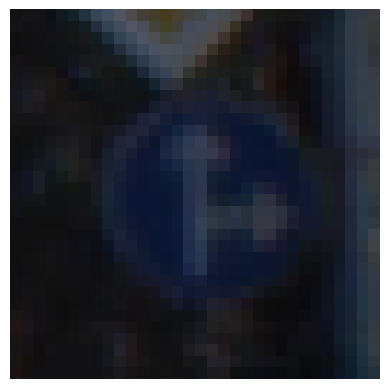

In [9]:
import cv2

plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000])

In [10]:
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

(32, 32)


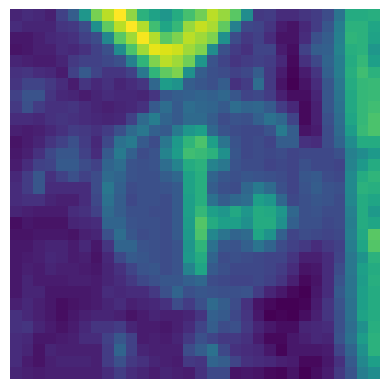

In [11]:
img = grayscale(X_train[1000])
plt.imshow(img)
plt.axis("off")
print(img.shape)

In [12]:
def equalize(img):
    img = cv2.equalizeHist(img)
    return img

(32, 32)


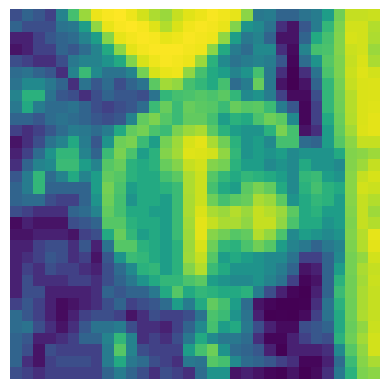

In [13]:
img = equalize(img)
plt.imshow(img)
plt.axis("off")
print(img.shape)

In [14]:
def preprocess(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img

In [15]:
X_train = np.array(list(map(preprocess, X_train)))
X_test = np.array(list(map(preprocess, X_test)))
X_val = np.array(list(map(preprocess, X_val)))

(34799, 32, 32)


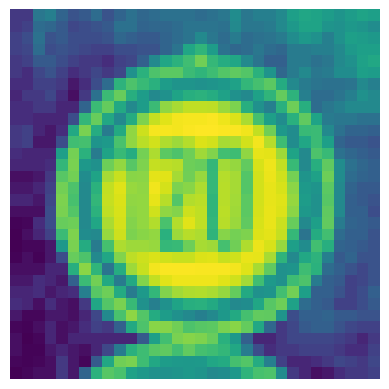

In [16]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis('off')
print(X_train.shape)

In [17]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)

In [53]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range = 0.1,
                            height_shift_range = 0.1,
                            zoom_range = 0.2,
                            shear_range = 0.1,
                            rotation_range = 10)

datagen.fit(X_train)

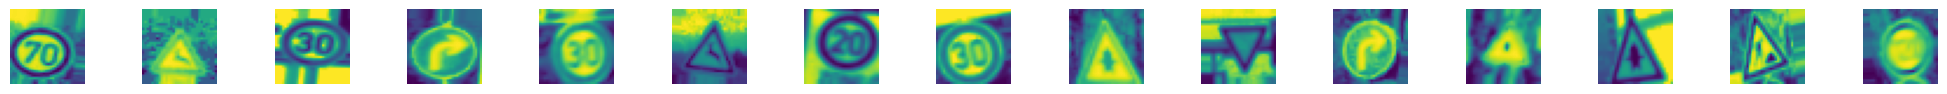

In [54]:
batches = datagen.flow(X_train, y_train, batch_size = 20)

X_batch, y_batch = next(batches)

fig, axs = plt.subplots(1, 15, figsize = (20, 5))
fig.tight_layout()

for i in range(15):
  axs[i].imshow(X_batch[i].reshape(32, 32))
  axs[i].axis('off')

In [18]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(34799, 32, 32, 1)
(12630, 32, 32, 1)
(4410, 32, 32, 1)


In [19]:
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

In [20]:
def modified_model():
  model = Sequential()
  model.add(tensorflow.keras.Input(shape = (32, 32, 1)))
  model.add(Conv2D(60, (5, 5), activation = 'relu'))
  model.add(Conv2D(60, (5, 5), activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2, 2)))
  model.add(Conv2D(30, (3, 3), activation = 'relu'))
  model.add(Conv2D(30, (3, 3), activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2, 2)))
  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(500, activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation = 'softmax'))
  model.compile(Adam(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
  return model

In [21]:
model = modified_model()

In [56]:
history = model.fit(datagen.flow(X_train, y_train, batch_size = 50), steps_per_epoch = 2000, epochs = 10, validation_data = (X_val, y_val), shuffle = 1)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 696/2000 ━━━━━━━━━━━━━━━━━━━━ 11:37 535ms/step - accuracy: 0.6437 - loss: 1.2668

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 386s 192ms/step - accuracy: 0.6919 - loss: 1.0664 - val_accuracy: 0.9635 - val_loss: 0.1202
Epoch 2/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 380s 190ms/step - accuracy: 0.8290 - loss: 0.5621 - val_accuracy: 0.9803 - val_loss: 0.0714
Epoch 3/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 390s 194ms/step - accuracy: 0.8692 - loss: 0.4266 - val_accuracy: 0.9905 - val_loss: 0.0408
Epoch 4/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 432s 189ms/step - accuracy: 0.8895 - loss: 0.3575 - val_accuracy: 0.9912 - val_loss: 0.0387
Epoch 5/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 382s 190ms/step - accuracy: 0.9049 - loss: 0.3006 - val_accuracy: 0.9914 - val_loss: 0.0313
Epoch 6/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 379s 189ms/step - accuracy: 0.9124 - loss: 0.2809 - val_accuracy: 0.9878 - val_loss: 0.0420
Epoch 7/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 381s 189ms/step - accuracy: 0.9234 - loss: 0.2476 - val_accuracy: 0.9891 - val_loss: 0.0391
Epoch 8/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 383s 189ms/step - accuracy: 0.9

Text(0.5, 0, 'epoch')

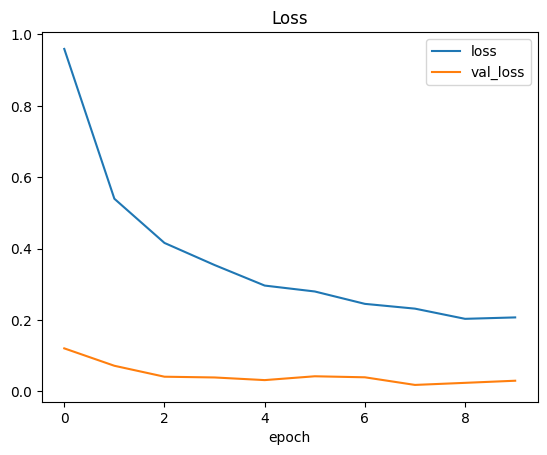

In [57]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

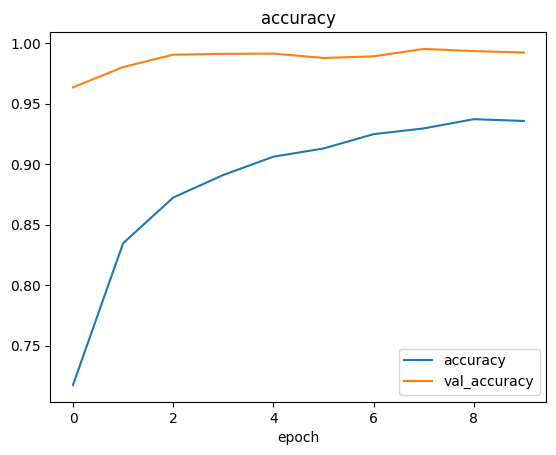

In [58]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.title('accuracy')
plt.xlabel('epoch')

In [26]:
score = model.evaluate(X_test, y_test, verbose = 0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.12822408974170685
Test accuracy: 0.9634204506874084


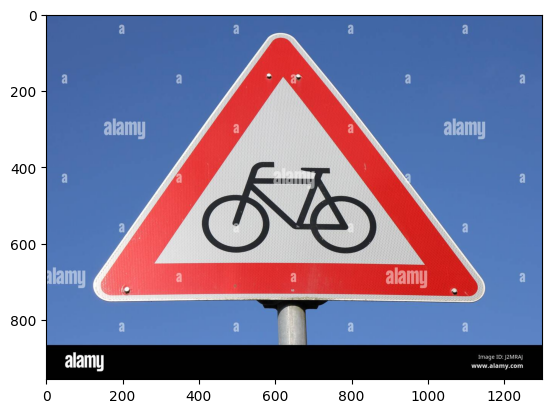

In [48]:
#fetch image

import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))


(32, 32)


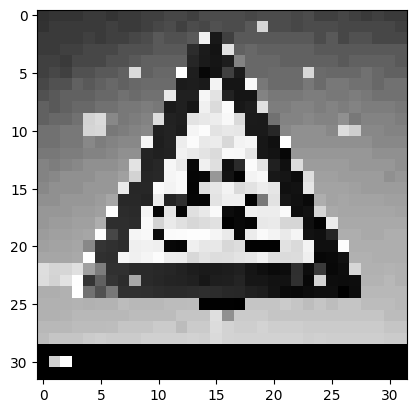

In [49]:
#Preprocess image

img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocess(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [50]:
#Reshape reshape

img = img.reshape(1, 32, 32, 1)

In [51]:
#Test image
print("predicted sign: "+ str(np.argmax(model.predict(img))))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
predicted sign: 24
